In [1]:
# COMP9444_GroupProject
# The Topic is Parkinson's Disease Progression Prediction
# The Model: LightGBM + Single Feature Optimization

In [2]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
import random as rnd
import pandas as pd
import numpy as np
from numpy import random as np_rnd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from tqdm import tqdm
from itertools import product
import gc

from sklearn.model_selection import GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics as skl_metrics

from sklearn import linear_model as lm
import lightgbm as lgb
from scipy.optimize import minimize

import warnings
warnings.filterwarnings(action='ignore')

OSError: dlopen(/Users/wzj/.conda/envs/lab2/lib/python3.10/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <F47D69E4-1594-3171-ABCC-7156C3E263E1> /Users/wzj/.conda/envs/lab2/lib/python3.10/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [4]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="w"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

def get_smape(y_true, y_pred, smoothing_factor=1.0):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true + smoothing_factor) + np.abs(y_pred + smoothing_factor)) / 2
    return np.nanmean(numerator / denominator) * 100

In [5]:
class CFG:
    debug = False

In [6]:
# Loading Data

train_clinical_data = pd.read_csv('train_clinical_data.csv')
train_clinical_data['source'] = 'standard'

supplemental_clinical_data = pd.read_csv('supplemental_clinical_data.csv')
supplemental_clinical_data['source'] = 'supplemental'

train_clinical_all = pd.concat([train_clinical_data, supplemental_clinical_data])

In [7]:
# drop outlier month
train_clinical_all = train_clinical_all[~train_clinical_all["visit_month"].isin([5])]

# delete visit_month 3, 9 (there are no such visit_months in the Test API)
# -> I think this is a sort of target leakage (but do same operation as original kernel)
train_clinical_all = train_clinical_all[~train_clinical_all["visit_month"].isin([3, 9])]

/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33990/461186036.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_group = train_clinical_all.groupby("visit_month").median()


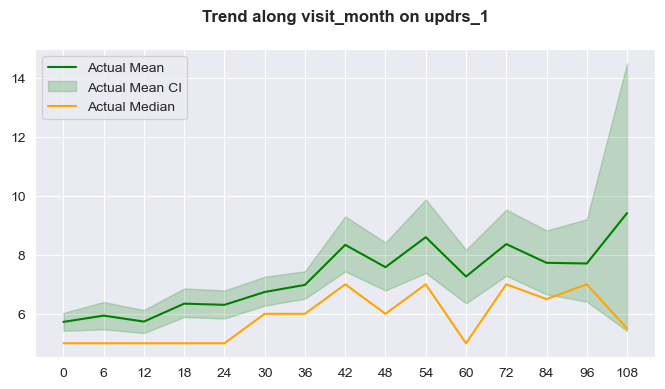

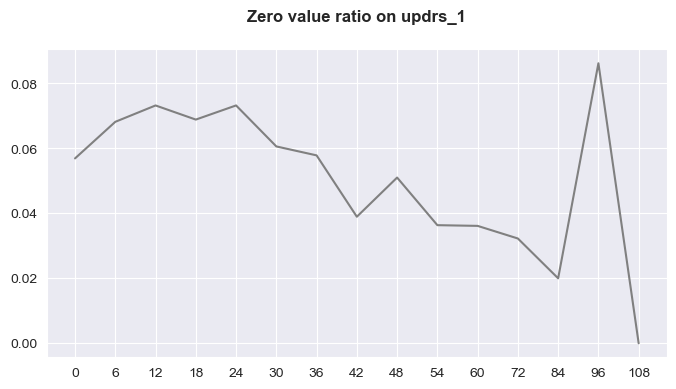

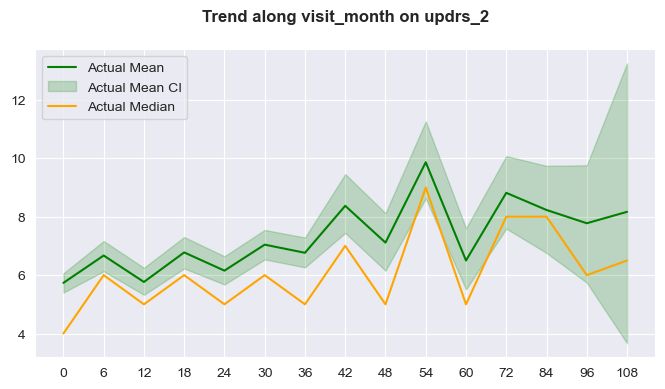

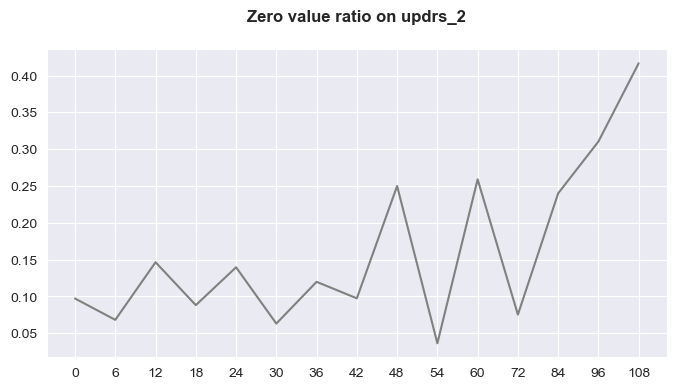

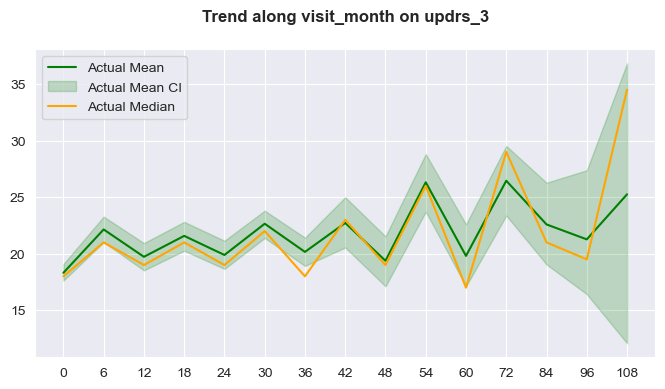

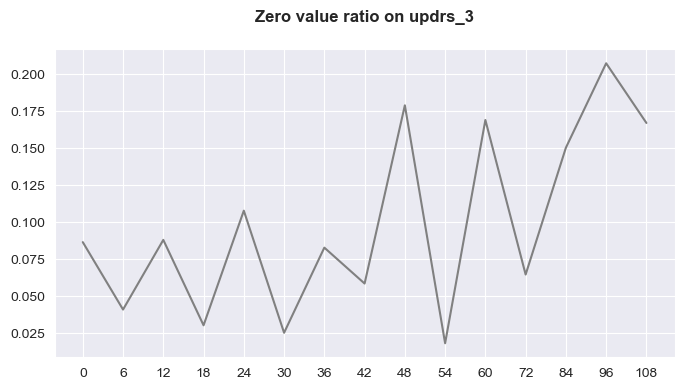

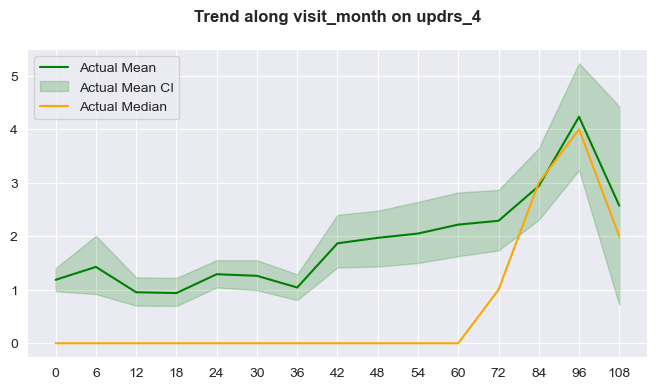

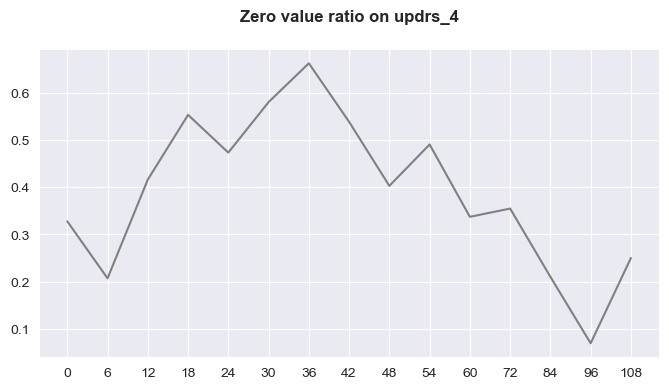

In [8]:
# Simple Visualization

df_group = train_clinical_all.groupby("visit_month").median()

for i in range(1, 5):
    target = f'updrs_{i}'
    fig = plt.figure(figsize=(8, 4))
    sns.lineplot(x=train_clinical_all["visit_month"].astype("str").values, y=train_clinical_all[target].values, color="green")
    sns.lineplot(x=df_group.index.astype("str").values, y=df_group[target].values, color="orange", errorbar=None)
    plt.legend(["Actual Mean", "Actual Mean CI", "Actual Median"], loc="upper left")
    plt.title(f"Trend along visit_month on {target}", pad=20, fontdict={"fontweight": "bold", "fontsize": 12})
    plt.show()

    df_group_zero = train_clinical_all[["visit_month", target]].copy()
    df_group_zero[target] = (df_group_zero[target] == 0).astype("int32")
    df_group_zero = df_group_zero.groupby("visit_month").mean()
    fig = plt.figure(figsize=(8, 4))
    sns.lineplot(x=df_group_zero.index.astype("str").values, y=df_group_zero[target].values, color="grey", errorbar=None)
    plt.title(f"Zero value ratio on {target}", pad=20, fontdict={"fontweight": "bold", "fontsize": 12})
    plt.show()



In [10]:
# Preprocesisng & Create data pipeline

train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

# renaming
train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)

In [12]:
# Create NPX & PA reference table

df_prot = pd.read_csv("train_proteins.csv")
df_prot.columns = df_prot.columns.str.lower()
df_prot["npx"] = np.log1p(df_prot["npx"])

npx_table = df_prot.pivot_table(index="visit_id", columns="uniprot", values="npx", aggfunc="mean").reset_index()
npx_table["patient_id"] = npx_table["visit_id"].apply(lambda x: x.split("_")[0]).astype("int64")
npx_table["visit_month"] = npx_table["visit_id"].apply(lambda x: x.split("_")[1]).astype("int32")
npx_table = npx_table.sort_values(["patient_id", "visit_month"]).set_index("visit_id")
npx_table = npx_table.fillna(0.0)
npx_uniprot_cols = npx_table.drop(["patient_id", "visit_month"], axis=1).columns

In [13]:
df_pept = pd.read_csv("train_peptides.csv")
df_pept.columns = df_pept.columns.str.lower()
df_pept = df_pept.rename(columns={"peptideabundance": "pa"})
df_pept["pa"] = np.log1p(df_pept["pa"])

pa_table = df_pept.pivot_table(index="visit_id", columns="peptide", values="pa", aggfunc="mean").reset_index()
pa_table["patient_id"] = pa_table["visit_id"].apply(lambda x: x.split("_")[0]).astype("int64")
pa_table["visit_month"] = pa_table["visit_id"].apply(lambda x: x.split("_")[1]).astype("int32")
pa_table = pa_table.sort_values(["patient_id", "visit_month"]).set_index("visit_id")
pa_table = pa_table.fillna(0.0)
pa_peptide_cols = pa_table.drop(["patient_id", "visit_month"], axis=1).columns


In [ ]:
train_clinical_all[[f"npx_{i}" for i in npx_uniprot_cols] + [f"pa_{i}" for i in pa_peptide_cols]] = -1.0
for idx, value in tqdm(zip(train_clinical_all.index, train_clinical_all["visit_id"]), total=len(train_clinical_all)):
    if value in npx_table.index:
        train_clinical_all.loc[idx, [f"npx_{i}" for i in npx_uniprot_cols]] = 0.0
        train_clinical_all.loc[idx, [f"npx_{i}" for i in npx_uniprot_cols]] = npx_table.loc[value, npx_uniprot_cols].values
    if value in pa_table.index:
        train_clinical_all.loc[idx, [f"pa_{i}" for i in pa_peptide_cols]] = 0.0
        train_clinical_all.loc[idx, [f"pa_{i}" for i in pa_peptide_cols]] = pa_table.loc[value, pa_peptide_cols].values

/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33990/3369660552.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_clinical_all[[f"npx_{i}" for i in npx_uniprot_cols] + [f"pa_{i}" for i in pa_peptide_cols]] = -1.0
/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33990/3369660552.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_clinical_all[[f"npx_{i}" for i in npx_uniprot_cols] + [f"pa_{i}" for i in pa_peptide_cols]] = -1.0
/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33990/336

In [16]:
# # Remove no protein & peptide information
# train_clinical_all = train_clinical_all[(~(train_clinical_all[[f"npx_{i}" for i in npx_uniprot_cols]] == -1).all(axis=1)).values].reset_index(drop=True)
# train_clinical_all = train_clinical_all[(~(train_clinical_all[[f"pa_{i}" for i in pa_peptide_cols]] == -1).all(axis=1)).values].reset_index(drop=True)

In [17]:
# Add TF-IDF embedding feature

npx_tfidf = TfidfVectorizer(token_pattern=r"[0-9a-zA-Z()_]+", lowercase=False, dtype="float32")
pa_tfidf = TfidfVectorizer(token_pattern=r"[0-9a-zA-Z()_]+", lowercase=False, dtype="float32")

df_npx_text = []
df_pa_text = []
for i in range(len(train_clinical_all)):
    df_npx_text.append(" ".join(np.array([f"npx_{i}" for i in npx_uniprot_cols])[(train_clinical_all[[f"npx_{i}" for i in npx_uniprot_cols]].iloc[i] > 0).values]))
    df_pa_text.append(" ".join(np.array([f"pa_{i}" for i in pa_peptide_cols])[(train_clinical_all[[f"pa_{i}" for i in pa_peptide_cols]].iloc[i] > 0).values]))

npx_tfidf.fit(df_npx_text)
pa_tfidf.fit(df_pa_text)

assert len(npx_tfidf.vocabulary_.keys()) == len(npx_uniprot_cols)
assert len(pa_tfidf.vocabulary_.keys()) == len(pa_peptide_cols)

train_clinical_all[[f"tfidf_{i}" for i in npx_tfidf.vocabulary_.keys()]] = npx_tfidf.transform(df_npx_text).toarray()
train_clinical_all[[f"tfidf_{i}" for i in pa_tfidf.vocabulary_.keys()]] = pa_tfidf.transform(df_pa_text).toarray()

del df_npx_text, df_pa_text; gc.collect()

/Users/wzj/.conda/envs/lab2/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(
/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33990/380561510.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_clinical_all[[f"tfidf_{i}" for i in npx_tfidf.vocabulary_.keys()]] = npx_tfidf.transform(df_npx_text).toarray()
/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33990/380561510.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

0

In [21]:
npx_svd_ncomp = 32
npx_svd = TruncatedSVD(npx_svd_ncomp, random_state=GLOBAL_SEED)
npx_svd.fit(train_clinical_all[[f"tfidf_{i}" for i in npx_tfidf.vocabulary_.keys()]])
train_clinical_all = pd.concat([
    train_clinical_all.drop([f"tfidf_{i}" for i in npx_tfidf.vocabulary_.keys()], axis=1),
    pd.DataFrame(npx_svd.transform(train_clinical_all[[f"tfidf_{i}" for i in npx_tfidf.vocabulary_.keys()]]), index=train_clinical_all.index, columns=[f"tfidf_svd_npx_{i}" for i in range(npx_svd_ncomp)]),
], axis=1)
print(npx_svd.explained_variance_ratio_.cumsum()[-1])

pa_svd_ncomp = 128
pa_svd = TruncatedSVD(pa_svd_ncomp, random_state=GLOBAL_SEED)
pa_svd.fit(train_clinical_all[[f"tfidf_{i}" for i in pa_tfidf.vocabulary_.keys()]])
train_clinical_all = pd.concat([
    train_clinical_all.drop([f"tfidf_{i}" for i in pa_tfidf.vocabulary_.keys()], axis=1),
    pd.DataFrame(pa_svd.transform(train_clinical_all[[f"tfidf_{i}" for i in pa_tfidf.vocabulary_.keys()]]), index=train_clinical_all.index, columns=[f"tfidf_svd_pa_{i}" for i in range(pa_svd_ncomp)]),
], axis=1)
print(pa_svd.explained_variance_ratio_.cumsum()[-1])


0.97054267
0.97182846


In [22]:
# Add NPX stats feature

npx_stats_table = df_prot.groupby("visit_id").agg({"npx": ["mean", "std", "max", "min"]})
npx_stats_table.columns = [f"npx_{i}" for i in ["mean", "std", "max", "min"]]
npx_stats_table["npx_range"] = (npx_stats_table["npx_max"] - npx_stats_table["npx_min"]).abs()
npx_stats_table = npx_stats_table.astype("float32").sort_index()
npx_stats_cols = list(npx_stats_table.columns)
display(npx_stats_table.head())

pa_stats_table = df_pept.groupby("visit_id").agg({"pa": ["mean", "std", "max", "min"]})
pa_stats_table.columns = [f"pa_{i}" for i in ["mean", "std", "max", "min"]]
pa_stats_table["pa_range"] = (pa_stats_table["pa_max"] - pa_stats_table["pa_min"]).abs()
pa_stats_table = pa_stats_table.astype("float32").sort_index()
pa_stats_cols = list(pa_stats_table.columns)
display(pa_stats_table.head())

,npx_mean,npx_std,npx_max,npx_min,npx_range
visit_id,,,,,
10053_0,12.057290,1.986118,19.410690,7.823582,11.587109
10053_12,12.117056,1.907277,19.414043,8.665936,10.748108
10053_18,11.897535,2.057158,19.446131,7.196769,12.249362
10138_12,11.931193,2.071008,19.717001,7.832506,11.884495
10138_24,11.799184,2.146130,19.799179,7.270967,12.528213


,pa_mean,pa_std,pa_max,pa_min,pa_range
visit_id,,,,,
10053_0,11.552876,1.655450,18.010212,4.430435,13.579777
10053_12,11.600553,1.622334,18.106783,4.863264,13.243518
10053_18,11.406043,1.653380,17.985445,4.695925,13.289520
10138_12,11.501849,1.684540,18.087337,4.867719,13.219618
10138_24,11.323711,1.764727,18.634962,4.967366,13.667595


In [23]:
train_clinical_all[npx_stats_cols + pa_stats_cols] = -1.0
for idx, value in tqdm(zip(train_clinical_all.index, train_clinical_all["visit_id"]), total=len(train_clinical_all)):
    if value in npx_table.index:
        train_clinical_all.loc[idx, npx_stats_cols] = npx_stats_table.loc[value].values
    if value in pa_table.index:
        train_clinical_all.loc[idx, pa_stats_cols] = pa_stats_table.loc[value].values


100%|██████████| 4506/4506 [00:01<00:00, 3269.81it/s]


In [24]:
# Add timeseries difference feature (deprecated)

# npx_diff_feature = [f"diff_{i}" for i in npx_stats_cols]
# pa_diff_feature = [f"diff_{i}" for i in pa_stats_cols]

# train_clinical_all[npx_diff_feature + pa_diff_feature] = \
#     train_clinical_all.groupby("patient_id", sort=False)[npx_stats_cols + pa_stats_cols].diff(1).fillna(0.0).values

In [35]:
# Feature Selection on NPX & PA feature

npx_fs_top_n = 16
pa_fs_top_n = 64
fs_dic = {}

def do_feature_selection():
    for i in range(1,5):
        target = f"updrs_{i}_plus_0"
        print(f"target {target}")
        fs_dic[target] = {}

        # npx
        npx_fs = []
        df_npx_fs = train_clinical_all[[target] + [f"npx_{i}" for i in npx_uniprot_cols]].dropna().reset_index(drop=True)
        df_npx_fs = df_npx_fs[~(df_npx_fs[[f"npx_{i}" for i in npx_uniprot_cols]] == -1).all(axis=1)].reset_index(drop=True)

        # method1: correlation
        df_corr = df_npx_fs.corr()[target].iloc[1:]
        npx_fs.extend(df_corr.index[df_corr.abs().argsort()[::-1]][:npx_fs_top_n].to_list())

        # method2: lasso shirinkage
        scaler = StandardScaler()
        model = lm.Lasso(alpha=1e-1)
        model.fit(scaler.fit_transform(df_npx_fs.drop(target, axis=1)), df_npx_fs[target])
        npx_fs.extend(list(df_npx_fs.drop(target, axis=1).columns[model.coef_ != 0][:npx_fs_top_n]))

        # method3: RandomForest feature importance
        fixed_params = {
            "boosting_type": "rf",
            "objective": "mae",
            "n_estimators": 100,
            "subsample": [0.75],
            "subsample_freq": 1,
            "colsample_bytree": [0.5],
            "num_leaves": 2**6-1,
            "verbose": -1,
            "device_type": "cpu",
            "importance_type": "gain",
            "random_state": GLOBAL_SEED,
        }
        model = lgb.LGBMRegressor(**fixed_params)
        model.fit(df_npx_fs.drop(target, axis=1), df_npx_fs[target])
        npx_fs.extend(list(df_npx_fs.drop(target, axis=1).columns[model.feature_importances_.argsort()[::-1]][:npx_fs_top_n]))
        fs_dic[target]["npx"] = sorted(set(npx_fs))
        print(len(fs_dic[target]["npx"]))

        # pa
        pa_fs = []
        df_pa_fs =  train_clinical_all[[target] + [f"pa_{i}" for i in pa_peptide_cols]].dropna().reset_index(drop=True)
        df_pa_fs = df_pa_fs[~(df_pa_fs[[f"pa_{i}" for i in pa_peptide_cols]] == -1).all(axis=1)].reset_index(drop=True)

        # method1: correlation
        df_corr = df_pa_fs.corr()[target].iloc[1:]
        pa_fs.extend(df_corr.index[df_corr.abs().argsort()[::-1]][:pa_fs_top_n].to_list())

        # method2: lasso shirinkage
        scaler = StandardScaler()
        model = lm.Lasso(alpha=1e-1)
        model.fit(scaler.fit_transform(df_pa_fs.drop(target, axis=1)), df_pa_fs[target])
        pa_fs.extend(list(df_pa_fs.drop(target, axis=1).columns[model.coef_ != 0][:pa_fs_top_n]))

        # method3: RandomForest feature importance
        fixed_params = {
            "boosting_type": "rf",
            "objective": "mae",
            "n_estimators": 100,
            "subsample": [0.75],
            "subsample_freq": 1,
            "colsample_bytree": [0.5],
            "num_leaves": 2**6-1,
            "verbose": -1,
            "device_type": "cpu",
            "importance_type": "gain",
            "random_state": GLOBAL_SEED,
        }
        model = lgb.LGBMRegressor(**fixed_params)
        model.fit(df_pa_fs.drop(target, axis=1), df_pa_fs[target])
        pa_fs.extend(list(df_pa_fs.drop(target, axis=1).columns[model.feature_importances_.argsort()[::-1]][:pa_fs_top_n]))
        fs_dic[target]["pa"] = sorted(set(pa_fs))
        print(len(fs_dic[target]["pa"]))

do_feature_selection()

# 对于 "updrs_1_plus_0"，选择了44个"npx"特征和168个"pa"特征。
# 对于 "updrs_2_plus_0"，选择了43个"npx"特征和167个"pa"特征。
# 对于 "updrs_3_plus_0"，选择了41个"npx"特征和171个"pa"特征。
# 对于 "updrs_4_plus_0"，选择了44个"npx"特征和157个"pa"特征。


target updrs_1_plus_0


NameError: name 'lgb' is not defined

In [27]:
train_clinical_all[train_clinical_all.select_dtypes("float").columns] = train_clinical_all[train_clinical_all.select_dtypes("float").columns].astype("float32")
train_clinical_all[train_clinical_all.select_dtypes("int").columns] = train_clinical_all[train_clinical_all.select_dtypes("int").columns].astype("int32")

In [28]:
display(train_clinical_all)

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,source,pred_month_plus_0,...,npx_mean,npx_std,npx_max,npx_min,npx_range,pa_mean,pa_std,pa_max,pa_min,pa_range
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,standard,0,...,12.070999,2.034070,19.782270,8.137018,11.645251,11.588550,1.613673,18.417688,7.672921,10.744767
1,55_6,55,6,8.0,10.0,34.0,NaN,NaN,standard,6,...,12.018382,2.053008,19.666483,7.826483,11.839999,11.530522,1.629884,18.167048,7.276065,10.890983
2,55_12,55,12,10.0,10.0,41.0,0.0,On,standard,12,...,12.084785,2.024951,19.764868,8.186888,11.577981,11.610638,1.617076,18.275810,7.942835,10.332976
3,55_18,55,18,7.0,13.0,38.0,0.0,On,standard,18,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,55_24,55,24,16.0,9.0,49.0,0.0,On,standard,24,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501,65303_36,65303,36,4.0,1.0,26.0,0.0,NaN,supplemental,36,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4502,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN,supplemental,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4503,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN,supplemental,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4504,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN,supplemental,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# Define Model & Training

ntrees = 100 if CFG.debug else 1000
eta = 1e-2

fixed_params = {
    "boosting_type": "goss",
    "objective": "mae",
    "n_estimators": ntrees,
    "num_leaves": 2**6-1,
    "verbose": -1,
    "device_type": "cpu",
    "importance_type": "gain",
    "random_state": GLOBAL_SEED,
}
dynamic_params = {
    "colsample_bytree": [0.5],
    "reg_lambda": [1.0],
#     "min_child_samples": [5, 20, 35],
}

def lgb_metric_smape(y_true, y_pred):
    """Calculate Metric Score"""
    score = get_smape(np.array(y_true), np.array(y_pred))
    # eval_name, eval_result, is_higher_better
    return 'smape', score, False

class LGB_CustomModel():
    def __init__(self):
        self.model_list = []
        self.eval_score_list = []
        self.ntrees = ntrees
        for idx, params in enumerate(product(*dynamic_params.values())):
            tmp_params = fixed_params.copy()
            tmp_params.update({k: v for k, v in zip(dynamic_params.keys(), params)})
            self.model_list.append(lgb.LGBMRegressor(**tmp_params))
    def fit(self, x, y, eval_x, eval_y):
        for model in self.model_list:
            model.fit(
                x, y,
                eval_set=[(eval_x, eval_y)], eval_metric=lgb_metric_smape,
                early_stopping_rounds=int(self.ntrees * 0.2), verbose=0,
            )
            pred = np.clip(np.round(model.predict(eval_x)), 0.0, None)
            self.eval_score_list.append(get_smape(eval_y.values, pred))
            mse = mean_squared_error(eval_y.values, pred)
            r2 = r2_score(eval_y.values, pred)
            print(f'MSE: {mse}, R2: {r2}')
        print("=== Best model & Score ===")
        print("Model :", self.model_list[np.argmin(self.eval_score_list)])
        print("Best ntrees :", self.model_list[np.argmin(self.eval_score_list)].best_iteration_)
        print("SMAPE :", self.eval_score_list[np.argmin(self.eval_score_list)])
    def predict(self, x):
        model = self.model_list[np.argmin(self.eval_score_list)]
        return model.predict(x)

class Model_GLM():
    def __init__(self):
        self.model = []
    def fit(self, x, y):
        self.model = list(minimize(
            fun=self.function_to_minimize,
            x0=[0.0] + ([0.0048] * x.shape[1]),
            args=(x, y),
            method='Powell'
        ).x)
        print("=== Coefficient ===")
        print(self.model)
        pred = self.predict(x)
        mse = mean_squared_error(y, pred)
        r2 = r2_score(y, pred)
        print(f'MSE: {mse}, R2: {r2}')
    def predict(self, x):
        output = [self.model[i] * np.ones(len(x)) if i == 0 else self.model[i] * x[:, (i-1)] for i in range(len(self.model))]
        return np.stack(output, axis=0).sum(axis=0)
    def function_to_minimize(self, model, x, y):
        output = [model[i] * np.ones(len(x)) if i == 0 else model[i] * x[:, (i-1)] for i in range(len(model))]
        return get_smape(y, np.clip(np.round(np.stack(output, axis=0).sum(axis=0)), 0.0, None))

def create_train_data(df, columns_with_target, columns_with_pred_month, addtional_features):
    df_output = pd.melt(df, id_vars=addtional_features, value_vars=columns_with_target).rename(columns={"value": "target"}).drop("variable", axis=1)
    tmp = pd.melt(train_clinical_all, id_vars=addtional_features, value_vars=columns_with_pred_month)
    df_output["plus_month"] = tmp["variable"].apply(lambda x: int(x.split("_")[-1])).astype("float32")
    df_output["pred_month"] =  tmp["value"].values
    df_output["visit_month"] = (df_output["pred_month"] - df_output["plus_month"]).values
    groups = []
    for i in df["patient_id"].values: groups.extend([i] * 4)
    df_output["patient_id"] = groups
    return df_output.dropna().reset_index(drop=True)


In [30]:
def do_training():
    for i in range(1, 5):
        target = f'updrs_{i}'
        scaler_dic[target] = {}
        model_dic[target] = {}

        print(f"===== Training on {target} =====\n")
        columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
        df_full = create_train_data(train_clinical_all, columns_with_target, columns_with_pred_month, addtional_features)
        df_full = df_full.sample(frac=1, random_state=GLOBAL_SEED).reset_index(drop=True)

        # adjusting zero values
#         if target == "updrs_2":
#             df_full = df_full[df_full["target"] != 0].reset_index(drop=True)
        if target == "updrs_3":
            df_full = df_full[df_full["target"] != 0].reset_index(drop=True)

        df_full_pred_month = df_full["pred_month"].values.copy()
        df_full_groups = df_full["patient_id"].values.copy()
        stratVec = (df_full["pred_month"].astype("str") + "_" + df_full["plus_month"].astype("str")).values

        # Feature selection on npx & pa feature
        drop_npx_features = pd.Series([f"npx_{i}" for i in npx_uniprot_cols])[~pd.Series([f"npx_{i}" for i in npx_uniprot_cols]).isin(fs_dic[f'{target}_plus_0']["npx"])].to_list()
        drop_pa_features = pd.Series([f"pa_{i}" for i in pa_peptide_cols])[~pd.Series([f"pa_{i}" for i in pa_peptide_cols]).isin(fs_dic[f'{target}_plus_0']["pa"])].to_list()
        df_full = df_full.drop(drop_npx_features + drop_pa_features, axis=1)

#         # Pre-processing on feature
#         if target == "updrs_4":
#             df_full["pred_month"] = np.clip(df_full["pred_month"], 54, None)
        df_full["pred_month_squared"] = df_full["pred_month"] ** 2
        df_full["pred_month_root"] = df_full["pred_month"] ** (1/2)

        print(f"Entire data shape on {target} ---> {df_full.shape}\n")
        train_features = list(df_full.drop(["target", "patient_id"], axis=1).columns)
        scaling_features = ["plus_month", "pred_month", "visit_month", "pred_month_squared", "pred_month_root"] + \
            pd.Series([f"npx_{i}" for i in npx_uniprot_cols])[pd.Series([f"npx_{i}" for i in npx_uniprot_cols]).isin(fs_dic[f'{target}_plus_0']["npx"])].to_list() + \
            pd.Series([f"pa_{i}" for i in pa_peptide_cols])[pd.Series([f"pa_{i}" for i in pa_peptide_cols]).isin(fs_dic[f'{target}_plus_0']["pa"])].to_list() + \
            npx_stats_cols + pa_stats_cols

        # === Stage1: Base Model Training ===
        scaler_dic[target]["lgb"] = []
        model_dic[target]["lgb"] = []
        valid_pred_list = []
        y_pred = np.zeros(len(df_full), dtype="float32")
        for idx, (train_idx, valid_idx) in enumerate(kfolds_spliter.split(X=df_full, y=stratVec, groups=df_full_groups)):
            df_train_x = df_full.iloc[train_idx][train_features]
            df_train_x = df_train_x.iloc[:100] if CFG.debug else df_train_x
            df_train_y = df_full.iloc[train_idx]["target"]
            df_train_y = df_train_y.iloc[:100] if CFG.debug else df_train_y
            df_valid_x = df_full.iloc[valid_idx][train_features]
            df_valid_y = df_full.iloc[valid_idx]["target"]

            if scaling:
                scaler = StandardScaler()
                df_train_x[scaling_features] = scaler.fit_transform(df_train_x[scaling_features])
                df_valid_x[scaling_features] = scaler.transform(df_valid_x[scaling_features])
                scaler_dic[target]["lgb"].append(scaler)

            model_lgb = LGB_CustomModel()
            model_lgb.fit(
                df_train_x, df_train_y,
                df_valid_x, df_valid_y,
            )
            # Post-processing on predictred value
            tmp_pred = model_lgb.predict(df_valid_x)
            model_dic[target]["lgb"].append(model_lgb)
            y_pred[valid_idx] = tmp_pred

        valid_pred_list.append(y_pred)
        print(f"Stage1 SMAPE Score ---> {get_smape(df_full['target'].values, np.clip(np.round(y_pred), 0, None)):.4f}\n")

        # === Stage2: Generalized Linear Model ===
        # Excute optimization process
        model_glm = Model_GLM()
        df_glm_x = np.stack(valid_pred_list, axis=-1)
        df_glm_y = df_full["target"].values
        model_glm.fit(df_glm_x, df_glm_y)
        y_glm_pred = model_glm.predict(df_glm_x)
        print(f"Stage2 SMAPE Score ---> {get_smape(df_full['target'].values, np.clip(np.round(y_glm_pred), 0.0, None)):.4f}\n")

        # === Single Feature Optimization ===
        model_sf = Model_GLM()
        df_sf_x = df_full[["pred_month"]].values
        df_sf_y = df_full["target"].values
        model_sf.fit(df_sf_x, df_sf_y)
        y_sf_pred = model_sf.predict(df_full[["pred_month"]].values)
        print(f"Single Feature Optimization SMAPE Score ---> {get_smape(df_full['target'].values, np.clip(np.round(y_sf_pred), 0.0, None)):.4f}\n")

        # Get ensemble prediction
        y_ensemble_pred = (y_glm_pred * ml_weight) + (y_sf_pred * (1 - ml_weight))
        y_ensemble_pred = np.clip(np.round(y_ensemble_pred), 0.0, None)

        print(f"Final Ensemble SMAPE Score ---> {get_smape(df_full['target'].values, y_ensemble_pred):.4f}\n")

        # Post-processing
        if target == "updrs_4":
            y_ensemble_pred[df_full_pred_month <= 54] = 0.0

        train_features_dic[target] = train_features
        scaling_features_dic[target] = scaling_features
        model_glm_dic[target] = model_glm
        model_sf_dic[target] = model_sf
        score_dic[target] = get_smape(df_full["target"].values, y_ensemble_pred)
        pred_dic[target] = pd.DataFrame()
        pred_dic[target]["pred_month"] = df_full_pred_month
        pred_dic[target]["y_true"] = df_full["target"].values
        pred_dic[target]["y_pred"] = y_ensemble_pred.copy()
        print("\n")


In [31]:
seed_everything()

n_folds = 3 if CFG.debug else 10
kfolds_spliter = StratifiedGroupKFold(n_folds, shuffle=True, random_state=GLOBAL_SEED)

columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]

addtional_features = \
    [f"npx_{i}" for i in npx_uniprot_cols] + [f"pa_{i}" for i in pa_peptide_cols] + \
    npx_stats_cols + pa_stats_cols + \
    [f"tfidf_svd_npx_{i}" for i in range(npx_svd_ncomp)] + [f"tfidf_svd_pa_{i}" for i in range(pa_svd_ncomp)]

train_features_dic = {}
scaling_features_dic = {}
scaler_dic = {}
model_dic = {}
model_glm_dic = {}
model_sf_dic = {}
score_dic = {}
pred_dic = {}
ml_weight = 0.2

scaling = True

In [32]:
%%time

seed_everything()

do_training()

===== Training on updrs_1 =====



KeyError: 'npx'

In [33]:
# Get CV SMAPE Score

print("=== SMAPE Score ===")
display(pd.Series(score_dic))
print("\n=== Average ===")
pd.Series(score_dic).mean().round(5)

=== SMAPE Score ===


/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33637/3111210890.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  display(pd.Series(score_dic))


Series([], dtype: float64)


=== Average ===


/var/folders/k9/g86hrqts7n92qt28xrl9pf9c0000gn/T/ipykernel_33637/3111210890.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(score_dic).mean().round(5)


AttributeError: 'float' object has no attribute 'round'

In [34]:
# Visualization on Predicted Value

for i in range(1, 5):
    target = f'updrs_{i}'
    df_eda = pred_dic[target].sort_values("pred_month")
    df_group = df_eda.groupby("pred_month").agg({"y_true": "median", "y_pred": "mean"})
    fig = plt.figure(figsize=(8, 4))
    sns.lineplot(x=df_eda["pred_month"].astype("int32").astype("str").values, y=df_eda["y_true"].values, color="green")
    sns.lineplot(x=df_group.index.astype("int32").astype("str").values, y=df_group["y_true"].values, color="orange", alpha=0.8, errorbar=None)
    sns.lineplot(x=df_group.index.astype("int32").astype("str").values, y=df_group["y_pred"].values, color="skyblue", linestyle="--", errorbar=None)
    plt.legend(["Actual Mean", "Actual Mean CI", "Actual Median", "Predicted Mean"], loc="upper left")
    plt.title(f"Average predicted updrs on Median of actual {target}", pad=20, fontdict={"fontweight": "bold", "fontsize": 12})
    plt.show()

KeyError: 'updrs_1'